In [61]:
from setup import *
from visualize import visualize
from utils import load_images_parallel, fun_images_parallel
from ganrec_dataloader import *
from models import *
from scipy.ndimage import gaussian_filter, median_filter
from skimage.data import shepp_logan_phantom, camera
from torchmetrics.image.psnr import PeakSignalNoiseRatio as PSNR
from torchmetrics.image.fid import FrechetInceptionDistance as FID
from torchmetrics.image.ssim import MultiScaleStructuralSimilarityIndexMeasure as mSSIM
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure as SSIM
import random
import time

def get_shape(image):
    if image is None:
        return None, None, None, None
    if type(image) is not list:
        image = [image]
    n_of_images= len(image)
    if len(image[0].shape) == 2:
        px, py = image[0].shape
        ND = n_of_images
        return ND, 1, px, py
    elif len(image[0].shape) == 3:
        shape = image[0].shape
        ND = min(shape)
        shape = [shape[i] for i in range(len(shape)) if shape[i] != ND]
        px, py = shape
        return n_of_images, ND, px, py
    elif len(image[0].shape) == 4:
        shape = image[0].shape
        if 1 in shape:
            shape = [shape[i] for i in range(len(shape)) if shape[i] != 1]
        ND = min(shape)
        shape = [shape[i] for i in range(len(shape)) if shape[i] != ND]
        channels = min(shape)
        shape = [shape[i] for i in range(len(shape)) if shape[i] != channels]
        px, py = shape
        return ND, channels, px, py
    else:
        raise ValueError("The input image has to be 2D, 3D or 4D")

def fresnel_calc(energy, z, pv):
    """z and pv have to in meters"""
    if energy is None or z is None or pv is None:
        return None
    if type(energy) is not list or type(z) is not list or type(pv) is not list:
        wavelength = wavelength_from_energy(eneryg_J(energy)).magnitude
        fresnel_number = pv**2/(wavelength*z) 
    else:
        energy = [energy] if type(energy) is not list else energy
        wavelength = [wavelength_from_energy(eneryg_J(ener)).magnitude for ener in energy]
        z = [z] if type(z) is not list else z
        pv = [pv] if type(pv) is not list else pv
        fresnel_number = []
        for i in range(len(energy)):
            for j in range(len(z)):
                for k in range(len(pv)):
                    fresnel_number.append(pv[k]**2/(wavelength[i]*z[j]))
    return  fresnel_number

def base_coeff(px = None, py=None, image=None):
    if [px, py] == [None, None]:
        ND, channels, px, py = get_shape(image)
    freq_1 = fftfreq(px)
    freq_2 = fftfreq(py)
    xi, eta = np.meshgrid(freq_1, freq_2)
    xi = xi.astype('float32')
    eta = eta.astype('float32')
    return np.exp((xi ** 2 + eta ** 2) / 2).T

def ffactor(energy=None, z=None, pv=None, px = None, py = None, image = None, fresnel_number = None):
    if px== None and py==None and image is not None:
        ND, channel, px, py = get_shape(image)
    if fresnel_number == None:
        fresnel_number = fresnel_calc(energy, z, pv)
    else:
        if [energy, z, pv] != [None, None, None]:
            if fresnel_number != fresnel_calc(energy, z, pv): 
                print("fresnel_number is not consistent with energy, z, and pv")
    
    basecoeff = base_coeff(px, py, image)
    if type(fresnel_number) is not list:
        ffs = basecoeff**(-1j*2*np.pi/fresnel_number)
    else:
        ffs = [basecoeff**(-1j*2*np.pi/fres) for fres in fresnel_number]
    return ffs

def propagate(energy=None, z=None, pv=None, px = None, py = None, fresnel_number = None, image = None, return_complex = False):
    if energy is not None and z is not None and pv is not None:
        ffs = ffactor(energy, z, pv, px, py, image)

    elif [energy, z ] == [None, None] and pv != None or [energy, pv] == [None, None] and z != None or [z, pv] == [None, None] and energy != None and fresnel_number != None:
        ffs = ffactor(energy, z, pv, px, py, image, fresnel_number)
    elif [energy, z, pv] == [None, None, None] and fresnel_number != None:
        basecoeff = base_coeff(px, py, image)
        if type(fresnel_number) is not list:
            ffs = basecoeff**(-1j*2*np.pi/fresnel_number)
        else:
            ffs = [basecoeff**(-1j*2*np.pi/fres) for fres in fresnel_number]
    else:
        ffs = None

    fft_image = np.fft.fft2(image)
    if type(ffs) is not list:
        propagated_images = [np.fft.ifft2(ffs * fft_image)]
    else:
        propagated_images = [np.fft.ifft2(ff * fft_image) for ff in ffs]
    if return_complex:
        return propagated_images
    else:
        return np.abs(propagated_images)**2

def prepare_dict(**kwargs):
    """
    make sure that the unit of energy is in keV, the unit of detector_pixel_size is in meter, and the unit of distance_sample_detector is in meter
    """
    similar_terms = [
        ['energy', 'eneryg_J', 'energy_kev'], 
        ['lam', 'lamda', 'wavelength', 'wave_length'],
        ['phase', 'phase_image'],
        ['attenuation', 'attenuation_image'],
        ['path', 'paths','images', 'i_inputs', 'path'],
        ['image_path', 'image_paths'],
        ['detector_pixel_size', 'pv'],
        ['distance_sample_detector', 'z'],
        ['fresnel_number', 'fresnel_number', 'fresnelnumbers', 'fresnelnumbers'],
        ['fresnel_factor', 'ffs', 'frensel_factors', 'fresnelfactor'],
        ['pad', 'pad_value', 'magnification_factor', 'upscale'],
        ['mode', 'pad_mode'],
        ['method', 'propagation_method'],
        ['alpha', 'alpha_value'],
        ['delta_beta', 'delta_beta_value'],
        ['idx', 'indices', 'index'],
        ['file_type', 'file_types', 'filetype', 'filetypes'],
        ['image', 'i_input', 'hologram', 'intensity'],
        ['shape_x', 'px'],
        ['shape_y', 'py'],
        ]
    for terms in similar_terms:
        for term in terms:
            if term in kwargs.keys():
                kwargs[terms[0]] = kwargs[term]
                break
        kwargs[terms[0]] = None if terms[0] not in kwargs.keys() else kwargs[terms[0]]

    kwargs['idx'] = [0] if kwargs['idx'] is None else kwargs['idx']
    kwargs['idx'] = [kwargs['idx']] if type(kwargs['idx']) is not list else kwargs['idx']
    if kwargs['image'] is None:
        if type(kwargs['path']) is list:
            kwargs['path'] = [kwargs['path'][i] for i in kwargs['idx']]
        if type(kwargs['path']) is not list:
            kwargs['path'] = [kwargs['path']]
        kwargs['image_path'] = []
        for path in kwargs['path']:
            if type(path) is str:
                if os.path.isdir(path):
                    kwargs['image_path'] += list(io.imread_collection(path + '/*.' + kwargs['file_type']).files)
                elif os.path.isfile(path):
                    kwargs['image_path'] += [path]
            elif 'collection' in str(type(path)):
                kwargs['image_path'] += path.files
            else:
                kwargs['image_path'] = kwargs['path']
        kwargs['image_path'] = [kwargs['image_path'][i] for i in kwargs['idx']] 
        kwargs['image'] = load_images_parallel(kwargs['image_path']) if kwargs['image_path'][0] is not None else None
    else:
        if type(kwargs['image']) is not list:
            kwargs['image'] = [kwargs['image']]

    
    kwargs['energy'] = None if 'energy' not in kwargs.keys() else kwargs['energy']
    kwargs['lam'] = wavelength_from_energy(eneryg_J(kwargs['energy'])).magnitude if kwargs['energy'] is not None else None
    kwargs['detector_pixel_size'] = None if 'detector_pixel_size' not in kwargs.keys() else kwargs['detector_pixel_size']
    kwargs['distance_sample_detector'] = None if 'distance_sample_detector' not in kwargs.keys() else kwargs['distance_sample_detector']
    kwargs['fresnel_number'] = None if 'fresnel_number' not in kwargs.keys() else kwargs['fresnel_number']
    kwargs['ffs'] = None if 'ffs' not in kwargs.keys() else kwargs['ffs']
    kwargs['base_coeff'] = None if 'base_coeff' not in kwargs.keys() else kwargs['base_coeff']
    kwargs['phase'] = None if 'phase' not in kwargs.keys() else kwargs['phase']
    kwargs['attenuation'] = None if 'attenuation' not in kwargs.keys() else kwargs['attenuation']
    kwargs['propagate'] = True if kwargs['phase'] is not None or kwargs['attenuation'] is not None else False

    kwargs['ND'], kwargs['channels'], kwargs['px'], kwargs['py'] = get_shape(kwargs['image'])
    kwargs['shape'] = [kwargs['px'], kwargs['py']]
    kwargs['shape_x'] = kwargs['px']
    kwargs['shape_y'] = kwargs['py']

    kwargs['fresnel_number'] = fresnel_calc(kwargs['energy'], kwargs['distance_sample_detector'], kwargs['detector_pixel_size']) if kwargs['fresnel_number'] is None else kwargs['fresnel_number']
    
    kwargs['base_coeff'] = [base_coeff(image = image) for image in kwargs['image']] if kwargs['image'] is not None else kwargs['base_coeff']
    if kwargs['fresnel_factor'] is not None:
        kwargs['fresnel_factor'] = [ffactor(energy = kwargs['energy'], z = kwargs['distance_sample_detector'], pv = kwargs['detector_pixel_size'], image = image, fresnel_number = kwargs['fresnel_number']) for image in kwargs['image']] if 'fresnel_factor' not in kwargs.keys() else kwargs['fresnel_factor']
    else:
        kwargs['ffs'] = [ffactor(energy = kwargs['energy'], z = kwargs['distance_sample_detector'], pv = kwargs['detector_pixel_size'], image = image) for image in kwargs['image']] if 'ffs' not in kwargs.keys() and kwargs['image'] is not None else kwargs['ffs']
    
    if 'propagate' in kwargs.keys() and kwargs['propagate'] == True:
        if 'phase' not in kwargs.keys(): 
            kwargs['phase'] = None
        if 'attenuation' not in kwargs.keys():
            kwargs['attenuation'] = None
        
        if kwargs['phase'] is not None:
            if type(kwargs['phase']) is not list:
                kwargs['phase'] = [kwargs['phase']]
            if type(kwargs['phase'][0]) is str:
                kwargs['phase'] = load_images_parallel(kwargs['phase'])
        
        if kwargs['attenuation'] is not None:
            if type(kwargs['attenuation']) is not list:
                kwargs['attenuation'] = [kwargs['attenuation']]
            if type(kwargs['attenuation'][0]) is str:
                kwargs['attenuation'] = load_images_parallel(kwargs['attenuation'])

        kwargs['phase'] = [nor_phase(phase)/np.max(nor_phase(phase)) for phase in kwargs['phase']] if kwargs['phase'] is not None else None
        kwargs['attenuation'] = [nor_phase(attenuation)/np.max(nor_phase(attenuation)) for attenuation in kwargs['attenuation']] if kwargs['attenuation'] is not None else None

        if kwargs['phase'] is not None and kwargs['attenuation'] is not None:
            kwargs['wavefunction'] = [np.exp(1j*kwargs['phase'][i] - kwargs['attenuation'][i]) for i in range(len(kwargs['phase']))]
        elif kwargs['phase'] is not None and kwargs['attenuation'] is None:
            kwargs['wavefunction'] = [np.exp(1j*kwargs['phase'][i] + np.zeros(kwargs['phase'][0].shape)) for i in range(len(kwargs['phase']))]
        elif kwargs['phase'] is None and kwargs['attenuation'] is not None:
            kwargs['wavefunction'] = [np.exp(1j * np.zeros(kwargs['attenuation'][0].shape) - kwargs['attenuation'][i]) for i in range(len(kwargs['attenuation']))]
        else:
            kwargs['wavefunction'] = kwargs['image']
        kwargs['propagated_images'] = [propagate(energy=kwargs['energy'], z=kwargs['distance_sample_detector'], pv=kwargs['detector_pixel_size'], fresnel_number=kwargs['fresnel_number'], image=kwargs['wavefunction'][i]) for i in range(len(kwargs['wavefunction']))] if 'propagated_images' not in kwargs.keys() else kwargs['propagated_images']
        
        if kwargs['image'] is None:
            kwargs['image'] = kwargs['propagated_images']
        if kwargs['path'] is None or kwargs['path'][0] is None:
            kwargs['path'] = kwargs['propagated_images']
        if kwargs['image_path'] is None:
            kwargs['image_path'] = os.getcwd()
        if kwargs['base_coeff'] is None:
            kwargs['base_coeff'] = [base_coeff(image = image) for image in kwargs['image']]
        if kwargs['fresnel_factor'] is None:
        
            kwargs['fresnel_factor'] = [ffactor(energy = kwargs['energy'], z = kwargs['distance_sample_detector'], pv = kwargs['detector_pixel_size'], image = image, fresnel_number=kwargs['fresnel_number']) for image in kwargs['image']]
    else:
        kwargs['propagated_images'] = kwargs['image']

    if 'pad' not in kwargs.keys():
        kwargs['pad'] = 1
    if 'pad_mode' not in kwargs.keys():
        kwargs['pad_mode'] = 'reflect'
    if 'alpha' not in kwargs.keys():
        kwargs['alpha'] = 1e-8
    if 'delta_beta' not in kwargs.keys():
        kwargs['delta_beta'] = 1e1
    if 'method' not in kwargs.keys():
        kwargs['method'] = 'GANREC'
    if 'downsampling_factor' not in kwargs.keys():
        kwargs['downsampling_factor'] = 1
    if 'save_path' not in kwargs.keys():
        kwargs['save_path'] = os.getcwd()
    if 'save_name' not in kwargs.keys():
        kwargs['save_name'] = 'reconstructed'
    if 'save_format' not in kwargs.keys():
        kwargs['save_format'] = 'tif'
    if 'save' not in kwargs.keys():
        kwargs['save'] = False
    if 'save_all' not in kwargs.keys():
        kwargs['save_all'] = False

    if kwargs['downsampling_factor'] != 1:
        kwargs['image'] = [resize(image, (image.shape[0]//kwargs['downsampling_factor'], image.shape[1]//kwargs['downsampling_factor']), anti_aliasing=True) for image in kwargs['image']] if kwargs['image'] is not None else None
        kwargs['detector_pixel_size'] = kwargs['detector_pixel_size'] * kwargs['downsampling_factor'] if kwargs['detector_pixel_size'] is not None else None
        if kwargs['fresnel_number'] is None:
            kwargs['fresnel_number'] = fresnel_calc(kwargs['energy'], kwargs['distance_sample_detector'], kwargs['detector_pixel_size'])  
        else:
            if type(kwargs['fresnel_number']) is not list:
                kwargs['fresnel_number'] = kwargs['fresnel_number']*kwargs['downsampling_factor']**2
            else:
                kwargs['fresnel_number'] = [kwargs['fresnel_number'][i]*kwargs['downsampling_factor']**2 for i in range(len(kwargs['fresnel_number']))]
        
        kwargs['base_coeff'] = [base_coeff(image = image) for image in kwargs['image']] if kwargs['image'] is not None else None
        kwargs['fresnel_factor'] = [ffactor(energy = kwargs['energy'], z = kwargs['distance_sample_detector'], pv = kwargs['detector_pixel_size'], image = image) for image in kwargs['image']] if 'fresnel_factor' not in kwargs.keys() and kwargs['image'] is not None else kwargs['fresnel_factor']
    return kwargs

class tensor_to_numpy(nn.Module):
    def __init__(self):
        super(tensor_to_numpy, self).__init__()
    def forward(self, x):
        return tensor_to_np(x)

class numpy_to_torch(nn.Module):
    def __init__(self, complex = False):
        super(numpy_to_torch, self).__init__()
        self.complex = complex
    def forward(self, x):
        return torch_reshape(x, complex = self.complex)
    
class gaussian_filtering(nn.Module):
    def __init__(self):
        super(gaussian_filtering, self).__init__()
    def forward(self, x, sigma):
        x = tensor_to_np(x)

        blurred = gaussian_filter(x, sigma)
        return torch_reshape(blurred, complex = False)
     
class Ganrec_Dataloader(torch.utils.data.Dataset):
    """
    The dataloader takes the different arguements and arranges it in a way that it can be used for the training and other purposes.
    ********************************
    Transform_type can be: 'reshape', 'normalize', 'contrast', 'contrast_normalize', 'brightness', 'norm'
    The image is then saved in the transformed_images variable. This will be used for the training.

    If there are multiple images, the idx variable is used to choose the image. 
    Batch_size is the number of images in the batch, which can be used for the training. 
    The batch_images variable is used to get the batch of images. The idx_batches variable is used to get the
    
    get_all_info() is used to get the information about the image and the fresnel factor.

    If phase and attenuation are provided, the forward propagation is done and saved in the propagated_forward variable.
    The fresnel factor is also saved in the fresnel_factor variable.
    ********************************
    """
    def __init__(self,**kwargs):
        self.kwargs = get_args()
        self.kwargs.update(kwargs)
        
        if 'downsampling_factor' not in self.kwargs.keys():
            self.kwargs['downsampling_factor'] = 1
        else:
            from skimage.transform import resize
            
        self.kwargs.update(prepare_dict(**kwargs))
        if 'phase' not in self.kwargs.keys() and 'attenuation' not in self.kwargs.keys():
            kwargs['phase'] = None
            kwargs['attenuation'] = None
        keys = self.kwargs.keys()
        [self.__setattr__(key, self.kwargs[key]) for key in keys]
        self.dims = (self.ND, self.shape_x, self.shape_y)
        self.transformed_images = transform(self.image, self.kwargs['transform_type'], self.kwargs['transform_factor']).requires_grad_(True)
        self.kwargs['transform_type'] = self.transform_type
        self.kwargs['transform_factor'] = self.transform_factor
        self.kwargs['transformed_images'] = self.transformed_images
        self.batch_size = self.transformed_images.shape[0]
        super(Ganrec_Dataloader, self).__init__()
        if 'mode' in self.kwargs.keys():
            self.mode = self.kwargs['mode']
        else:
            self.mode = 'reflect'
        if 'value' in self.kwargs.keys():
            self.value = self.kwargs['value']

    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx = None, transform_type = None): 
            
        if idx is not None:
            kwargs = self.kwargs
            if transform_type is not None:
                kwargs['transform_type'] = transform_type
            kwargs["idx"] = idx
            new = Ganrec_Dataloader(**kwargs)
            return new.transformed_images
        else:
            return self.transformed_images
    
    def __getbatchimages__(self, batch_size = None, transform_type = None):
        """
        Returns a batch of transformed images:
        ********************************
        batch_images, idx_batches = dataloader.__getbatchimages__(batch_size = 100, transform_type = 'reshape')
        for i, image in enumerate(batch_images):
            print(image.shape)
        ********************************
        """
        if batch_size is None:
            batch_size = self.batch_size
        if transform_type is None:
            transform_type = self.kwargs['transform_type']
        all_images = self.all_images
        n = len(all_images)
        seed = self.seed
        import random
        random.seed(seed)
        all_idx = list(range(n))
        random.shuffle(all_idx)
        idx_batches = [all_idx[i:i + batch_size] for i in range(0, n, batch_size)]
        batch_images = []
        from joblib import Parallel, delayed
        n_jobs = max(30, len(idx_batches))
        batch_images = Parallel(n_jobs=n_jobs)(delayed(self.__getitem__)(idx, transform_type) for idx in idx_batches)
        return batch_images, idx_batches
    
    def update_values(self, change_all = False, **info):
        """
        This function is used to update the values of the dataloader. 
        If the change is a shouldn't affect values from the get_all_info() function, then change_all should be False.
        Otherwise, it should be True.
        """

        if change_all:
            kwargs = self.kwargs
            kwargs.update(info)
            kwargs.update(get_all_info(**kwargs))
            [self.__setattr__(key, kwargs[key]) for key in kwargs.keys()]
            self.transformed_images = transform(self.image, kwargs['transform_type'], kwargs['transform_factor'])
            self.dims = (self.ND, self.shape_x, self.shape_y)
            print(self.kwargs['transform_type'])
        else:
            kwargs = self.kwargs
            kwargs.update(info)
            [self.__setattr__(key, info[key]) for key in info.keys()]
            # if 'transform_type' in info.keys() or 'transform_factor' in info.keys():
            #     self.transformed_images = transform(self.image, self.kwargs['transform_type'], self.kwargs['transform_factor'])
            #     self.dims = (self.ND, self.shape_x, self.shape_y)
            #     print(self.kwargs['transform_type'])
        
        return self
            
    def normalize(self, idx = None, transform_type = None):
        image = self.__getitem__(idx, transform_type)
        # image = torchnor_phase(image)
        return image
    
    def get_kwargs(self):
        return self.__dict__
    
    def visualize(self, idx = None, show_or_plot = 'show', tranformed = False):
        if idx is not None:
            kwargs = self.kwargs
            kwargs["idx"] = idx
            new = Ganrec_Dataloader(**kwargs)
        else:
            new = self
        if tranformed:
            images = new.transformed_images
            try:
                images = images[:,0,:,:].detach().cpu().numpy()
            except:
                images = images[0,:,:].numpy()
        else:
            images = new.image

        if type(images) is not list:
            # images = [images]
            images = list(images)
        fig = visualize(images, show_or_plot = show_or_plot)
        return fig
    
    def forward_propagate(self, distance = None):
        distance = self.distance_sample_detector if distance is None else distance
        wavefield = None if 'wavefield' not in self.kwargs.keys() else self.kwargs['wavefield']

        if type(distance) is not list:
            self.propagated_forward = forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = distance, phase_image = self.phase, attenuation_image = self.attenuation, fresnel_factor  = self.fresnel_factor, wavefield = wavefield, distance = distance, mode = self.mode, value = self.value)
        else:
            propagated_forward = [forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = distance[i], phase_image = self.phase, attenuation_image = self.attenuation, fresnel_factor  = None, wavefield = wavefield, distance = distance[i], mode=self.mode, value=self.value) for i in range(len(distance))]
            self.propagated_forward = torch.stack(propagated_forward, dim = 0)[:,0,:,:,:]
            print(self.propagated_forward.shape)
        return self.propagated_forward


class make_ganrec_model(nn.Module):
    def __init__(self, shape_x, shape_y, conv_num, conv_size, dropout, output_num, fresnel_factor, transformed_images=None, device=None, **kwargs):
        super(make_ganrec_model, self).__init__()
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.device = device
        if self.device is None:
            self.device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
        
        self.base_coeff = to_device(torch_reshape(self.base_coeff, complex=True), self.device) if self.base_coeff is not None else None
        self.fresnel_factor = to_device(torch_reshape(fresnel_factor, complex=True), self.device) if fresnel_factor is not None else None
        self.transformed_images = to_device(transformed_images, self.device) 
        self.image = to_device(self.image, self.device)
        self.shape_x = shape_x
        self.shape_y = shape_y
        self.conv_num = conv_num
        self.conv_size = conv_size
        self.dropout = dropout
        self.output_num = output_num
        self.units = kwargs['units'] if 'units' in kwargs.keys() else 128
        self.fc_size = shape_x * shape_y


        random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        np.random.seed(self.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        
        if 'mode' in kwargs.keys():
            self.mode = kwargs['mode']
        else:
            self.mode = 'constant'
        if 'value' in kwargs.keys():
            self.value = kwargs['value']
        else:
            self.value = 'mean'
        if 'abs_ratio' in kwargs.keys():
            self.abs_ratio = kwargs['abs_ratio']
        else:
            self.abs_ratio = 1
        ##################################################################################################
        # We first define the generator model
        ##################################################################################################
        
        
        if self.fc_depth == 0:
            self.fc_stack = []
        else:
            units = [self.units]*self.fc_depth
            self.fc_submodule = nn.ModuleList([
                dense_layer(in_features=self.units, out_features=self.units, dropout=self.dropout) for i in range(len(units))
            ])
            self.fc_stack = nn.ModuleList([
                nn.Flatten(),
                Transpose(),
                dense_layer(in_features=1, out_features=self.units, dropout=self.dropout, transpose=False),
                *self.fc_submodule,
                dense_layer(in_features=self.units, out_features=1, dropout=0),
                Reshape((-1, 1, self.shape_x, self.shape_y)),
            ])


        if self.cnn_depth == 0:
            self.cnn_stack = []
        else:
            conv_size_add_list = [2,3,4,5]# list(np.arange(1,self.cnn_depth+1))
            deconv_size_add_list = [5,4,3,2]# list(np.arange(self.cnn_depth+1, 1, -1))
            self.conv_stack = nn.ModuleList([
                conv2d_layer(in_channels=conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+conv_size_add_list[i], stride=1, apply_batchnorm=True, normal_init=True) for i in range(len(conv_size_add_list))
            ])
            
            self.dconv_stack = nn.ModuleList([
                deconv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+deconv_size_add_list[i], stride=1, apply_batchnorm=True, normal_init=True) for i in range(len(deconv_size_add_list))
            ])

            
        self.cnn_stack = nn.ModuleList([      
            conv2d_layer(in_channels=1, out_channels=self.conv_num, kernel_size=self.conv_size, stride=1), 
            *self.conv_stack,
            *self.dconv_stack,
            deconv2d_layer(in_channels=self.conv_num, out_channels=self.output_num, kernel_size=self.conv_size, stride=1),
        ])
        
        self.generator_model = to_device(nn.Sequential(
            *self.fc_stack,
            *self.cnn_stack,
        ), self.device)

        if 'init_model' in kwargs.keys():
            if kwargs['init_model']:
                # Load the model
                init_model_path = kwargs.get('init_model_path', 'model/ganrec_model')
                self.generator_model.load_state_dict(torch.load(init_model_path))

        else:
            self.init_weights()

        ##################################################################################################
        # We then define the discriminator model
        ##################################################################################################
        in_channels_list = list(2**np.arange(self.dis_depth)) # [1, 16, 16, 32, 32]
        out_channels_list =list(2**np.arange(1,self.dis_depth+1)) #[16, 16, 32, 32, 64]
        kernel_size_list = [self.conv_num]*len(in_channels_list) #[3,3,3,3,3]
        stride_list = [1]*len(in_channels_list) #[2,2,2,2,2]
        discriminator_stack = nn.ModuleList([
            conv2d_layer(in_channels=in_channels_list[i], out_channels=out_channels_list[i], kernel_size=kernel_size_list[i], stride=stride_list[i]) for i in range(len(in_channels_list))
        ])

        self.discriminator_model =  to_device(nn.Sequential(
            *discriminator_stack,
            nn.Flatten(),
        ), self.device)

        if 'task' not in kwargs.keys():
            self.task = 'phase_retrieval'

        if self.task == 'learn_gaussian':
            self.gaussian_filter = to_device(gaussian_filtering(), self.device)

        self.ssim = to_device(SSIM(), self.device)
        self.psnr = to_device(PSNR(), self.device)
        

        self.reshaped = to_device(transform(self.transformed_images, 'reshape') , self.device)
        self.normalized = transform(self.reshaped, 'normalize')
        self.norm = transform(self.reshaped, 'norm')
        self.contrast = transform(self.reshaped, 'contrast', self.transform_factor)
        self.contrast_normalize = transform(self.reshaped, 'constrast_normalize', self.transform_factor)
        self.brightness = transform(self.reshaped, 'brightness', self.transform_factor)
        self.brightness_normalize = transform(self.reshaped, 'brightness_normalize', self.transform_factor)
        self.fourier = torch.fft.fft2(self.reshaped)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)

    def refine_parameters_using_condition(self, condition, values, change_from_soure = False, info = None, ratio = None, plot_pandas=False, show_images=False):
        if ratio is None:
            ratio = {'l1_ratio': 10, 'contrast_ratio': 0, 'normalized_ratio': 5, 'brightness_ratio': 0, 'contrast_normalize_ratio': 0, 'brightness_normalize_ratio': 0, 'l2_ratio': 0, 'fourier_ratio': 1}

        df = pd.DataFrame(columns=[condition, 'iter_num', 'gen_loss', 'dis_loss', 'main_diff',  'setup_info'])
        df.index.name = condition
        last_phases = []
        last_atts = []
        last_props = []
        
        if type(values) is not list:
            values = [values]
            
        for value in values:            
                
            if change_from_soure == True:
                info[condition] = value if condition in info.keys() else info.update({condition: value})
                new_dataloader = Ganrec_Dataloader(**info)
                model = make_ganrec_model(**new_dataloader.__dict__)
            else:
                kwargs = self.__dict__
                kwargs[condition] = value if condition in kwargs.keys() else kwargs.update({condition: value})
                model = make_ganrec_model(**kwargs)
            
            gen_loss_list, dis_loss_list, propagated_intensity_list, phase_list, attenuation_list = model.train(save_model = False, save_model_path = 'model/ganrec_model', **ratio)
            print('gen_loss: ', gen_loss_list[-1], 'dis_loss: ', dis_loss_list[-1], 'main_diff: ', model.main_diff_list[-1])
            df.loc[value, condition] = value
            df.loc[value, 'iter_num'] = len(gen_loss_list)
            df.loc[value, 'gen_loss'] = gen_loss_list[-1]
            df.loc[value, 'dis_loss'] = dis_loss_list[-1]
            df.loc[value, 'main_diff'] = model.main_diff_list[-1]
            df.loc[value, 'setup_info'] = get_file_nem(model.__dict__)
            last_props.append(propagated_intensity_list[-1])
            last_phases.append(phase_list[-1])
            last_atts.append(attenuation_list[-1])
        column_range = ['main_diff', 'gen_loss', 'dis_loss']
        #list_element.index(element)
        min_vals = [df[column].min() for column in column_range], [df[column].idxmin() for column in column_range]
        max_vals = [df[column].max() for column in column_range], [df[column].idxmax() for column in column_range]
        indices_in_values = [values.index(min_vals[1][i]) for i in range(len(min_vals[1]))] 
        if plot_pandas:         
            plot_pandas(df, column_range, x_column = condition)
        if show_images:
            visualize([last_props[-1], last_phases[-1], last_atts[-1]], title = ['propagated_intensity', 'phase', 'attenuation'])
        return df, last_props, last_phases, last_atts, min_vals, max_vals, indices_in_values

    def make_model(self):
        # self.generator = self.generator_model
        # self.discriminator = self.discriminator_model
        self.generator_optimizer = torch.optim.Adam(self.generator_model.parameters(), lr=1e-3)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator_model.parameters(), lr=1e-5)
        
    def forward_generator(self, x):
        self.pred = self.generator_model(x)
        return self.pred

    def forward_discriminator(self, x):
        self.likelihood = self.discriminator_model(x)
        return self.likelihood
    
    def transform(self, x):
        if 'transform_type' in self.kwargs.keys():
            transform_type = self.transform_type
        else:
            transform_type = 'normalize'

        if 'transform_factor' in self.kwargs.keys():
            transform_factor = self.transform_factor
        else:
            transform_factor = 0.1
        return transform(x, transform_type, transform_factor)

    def propagator(self):
        phase = transform(self.pred[:,0,:,:], 'normalize') #*2 -1) * torch.pi
        attenuation =  (1 - transform(self.pred[:,1,:,:], 'normalize'))*self.abs_ratio
        propagated_intensity = transform(forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = self.distance_sample_detector, phase_image = phase, attenuation_image = attenuation, fresnel_factor  = self.fresnel_factor, wavefield = None, distance =  self.distance_sample_detector, mode = self.mode, value = self.value), self.transform_type, self.transform_factor)
        self.difference = propagated_intensity - self.transformed_images
        self.main_diff = torch.mean(torch.abs(self.difference))

        return propagated_intensity, phase, attenuation
    
    def gaussian_conv(self, x = None, sigma = None):
        if sigma is None:
            sigma = self.sigma
        if x is None:
            x = self.transform(self.pred)
        self.blurred = transform(to_device(self.gaussian_filter(x, sigma), self.device), self.transform_type, self.transform_factor)
        self.difference = self.blurred - self.transformed_images
        if self.l1_ratio != 0:
            self.main_diff = torch.mean(torch.abs(self.difference))
        else:
            self.main_diff = torch.mean(torch.square(self.difference))
        return self.blurred, x
        
    
    def forward(self, x = None):
        x = self.transformed_images if x is None else x
        self.pred = self.generator_model(x)
        propagated_intensity, phase, attenuation = self.propagator()
        self.fake_output = self.discriminator_model(propagated_intensity)
        self.real_output = self.discriminator_model(x)
        return self.fake_output, self.real_output, propagated_intensity, phase, attenuation
    
    def forward_gaussian(self, x):
        self.pred = self.generator_model(x)
        self.propagated_intensity, self.unblurred = self.gaussian_conv(self.pred, self.sigma)
        self.fake_output = self.discriminator_model(self.propagated_intensity)
        self.real_output = self.discriminator_model(x)
        return self.fake_output, self.real_output, self.propagated_intensity, self.unblurred
    

    def generator_loss(self, fake_output, x, propagated_intensity):
        cross_entropy = torch.mean(torch.nn.BCEWithLogitsLoss()(fake_output, torch.ones_like(fake_output)))
        if self.l1_ratio == 0:
            l2_loss = self.main_diff if self.l2_ratio != 0 else 0
            l1_loss = 0
        else:
            l1_loss =self.main_diff if self.l1_ratio != 0 else 0
            l2_loss = torch.mean(torch.square(self.difference)) if self.l2_ratio != 0 else 0
        
        contrast_diff = torch.mean(torch.abs(self.contrast - transform(propagated_intensity, 'contrast', self.transform_factor))) if self.contrast_ratio != 0 else 0
        contrast_noramlize_difference = torch.mean(torch.square(self.contrast_normalize - transform(propagated_intensity, 'contrast_normalize', self.transform_factor))) if self.contrast_normalize_ratio != 0 else 0
        brightness_noramlize_difference = torch.mean(torch.square(self.brightness_normalize - transform(propagated_intensity, 'brightness_normalize', 1 - self.transform_factor))) if self.brightness_normalize_ratio != 0 else 0
        brightness_diff = torch.mean(torch.square(self.brightness - transform(propagated_intensity, 'brightness', 1 - self.transform_factor))) if self.brightness_ratio != 0 else 0
        
        norm_diff = torch.mean(torch.abs(self.norm - transform(propagated_intensity, 'norm', self.transform_factor))) if self.norm_ratio != 0 else 0
        normalized_diff = torch.mean(torch.abs(self.normalized - transform(propagated_intensity, 'normalize', self.transform_factor))) if self.normalized_ratio != 0 else 0
        
        #use logaritmic loss for the fourier difference
        fourier_diff_real = torch.mean(torch.square(torch.log(torch.abs(torch.fft.fft2(propagated_intensity).real + 1e-10)))) if self.fourier_ratio != 0 else 0
        fourier_diff_imag = torch.mean(torch.square(torch.log(torch.abs(torch.fft.fft2(propagated_intensity).imag + 1e-10)))) if self.fourier_ratio != 0 else 0
        fourier_diff = fourier_diff_real + fourier_diff_imag

        #L2 regularization
        # self.gradient_of_propagated_intensity = torch.autograd.grad(outputs=propagated_intensity, inputs=self.pred, grad_outputs=torch.ones_like(propagated_intensity), retain_graph=True, create_graph=True)[0]
        
        reg_l2_loss = torch.mean(torch.square(self.pred)) if self.reg_l2_ratio != 0 else 0

        self.final_loss =  self.entropy_ratio * cross_entropy + self.l1_ratio * l1_loss + self.contrast_ratio * contrast_diff + self.norm_ratio * norm_diff + self.normalized_ratio * normalized_diff + self.brightness_ratio * brightness_diff + self.contrast_normalize_ratio * contrast_noramlize_difference + self.brightness_normalize_ratio * brightness_noramlize_difference + self.l2_ratio * l2_loss + self.fourier_ratio * fourier_diff
        return self.final_loss + self.reg_l2_ratio * reg_l2_loss
    
    def discriminator_loss(self, real_output, fake_output):
        real_loss = torch.mean(torch.nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output)))
        fake_loss = torch.mean(torch.nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output)))
        self.total_loss = self.real_loss_ratio * real_loss + self.fake_loss_ratio * fake_loss
        return self.total_loss
    
    def train_step(self, x):
        self.generator_optimizer.zero_grad()
        self.discriminator_optimizer.zero_grad()
        if self.task == 'learn_gaussian':
            self.fake_output, self.real_output, self.propagated_intensity, self.unblurred = self.forward_gaussian(x)
        else:
            self.fake_output, self.real_output, self.propagated_intensity, self.phase, self.attenuation = self.forward(x)
        self.gen_loss = self.generator_loss(self.fake_output, x, self.propagated_intensity)
        self.dis_loss = self.discriminator_loss(self.real_output, self.fake_output)
        self.gen_loss.backward(retain_graph=True)
        self.dis_loss.backward()
        self.generator_optimizer.step()
        self.discriminator_optimizer.step()
        if self.task == 'learn_gaussian':
            return self.gen_loss, self.dis_loss, self.propagated_intensity, self.unblurred
        else:
            return self.gen_loss, self.dis_loss, self.propagated_intensity, self.phase, self.attenuation
        
    def train(self, iter_num = None, save_model = None, save_model_path = None, **ratio): # l1_ratio = 10, contrast_ratio = 0, normalized_ratio = 0, norm_ratio = 0, brightness_ratio = 0, contrast_normalize_ratio = 0, brightness_normalize_ratio = 0, l2_ratio = 0, fourier_ratio = 0):
        for key, value in ratio.items():
            setattr(self, key, value)
        # [self.l1_ratio, self.contrast_ratio, self.normalized_ratio, self.brightness_ratio, self.contrast_normalize_ratio, self.norm_ratio, self.brightness_normalize_ratio, self.l2_ratio, self.fourier_ratio] = [l1_ratio, contrast_ratio, normalized_ratio, norm_ratio, brightness_ratio, contrast_normalize_ratio, brightness_normalize_ratio, l2_ratio, fourier_ratio]
        iter_num = self.iter_num if iter_num is None else iter_num
        save_model = self.save_model if save_model is None else save_model
        save_model_path = self.save_model_path if save_model_path is None else save_model_path

        self.make_model()
        self.gen_loss_list, self.dis_loss_list, self.propagated_intensity_list, self.phase_list, self.attenuation_list, self.main_diff_list, self.epoch_time, self.ssim_list, self.psnr_list = [], [], [], [], [], [], [], [], []
        if self.task == 'learn_gaussian':
            self.unblurred_list = []

        
        self.start_time = time.time()  
        for i in range(iter_num):
            self.epoch = i
            if self.task == 'learn_gaussian':
                self.g_loss, self.d_loss, self.propagated_intensity, self.unblurred = self.train_step(self.transformed_images)
                self.unblurred_list.append(tensor_to_np(self.unblurred))
            else:
                self.g_loss, self.d_loss, self.propagated_intensity, self.phase, self.attenuation = self.train_step(self.transformed_images)
                self.phase_list.append(tensor_to_np(self.phase))
                self.attenuation_list.append(tensor_to_np(self.attenuation))
            self.gen_loss_list.append(tensor_to_np(self.gen_loss))
            self.dis_loss_list.append(tensor_to_np(self.dis_loss))
            self.main_diff_list.append(tensor_to_np(self.main_diff))
            self.propagated_intensity_list.append(tensor_to_np(self.propagated_intensity))
            self.epoch_time.append(time.time() - self.start_time)

            if i ==0 or (i+1) % (self.iter_num//7) == 0:
                print('epoch', i, 'gen_loss: ', self.g_loss, 'dis_loss: ', self.d_loss, 'main_diff: ', self.main_diff, "t_epoch: ", self.epoch_time[-1], "remaining time: ", time_to_string(self.epoch_time[0] * iter_num - self.epoch_time[0] * i), 'ssim: ', tensor_to_np(self.ssim(self.transformed_images, self.propagated_intensity)), 'psnr: ', tensor_to_np(self.psnr(self.transformed_images, self.propagated_intensity)))
            
        if save_model is True and save_model_path is not None:
            torch.save(self.generator_model.state_dict(), save_model_path)
        self.total_time = time.time() - self.start_time

        if self.task == 'learn_gaussian':
            return self.gen_loss_list, self.dis_loss_list, self.propagated_intensity_list, self.unblurred_list
        else:
            return self.gen_loss_list, self.dis_loss_list, self.propagated_intensity_list, self.phase_list, self.attenuation_list


    def live_plot(self, iter_num = None, rate = 1):
        import matplotlib.pyplot as plt
        from IPython.display import clear_output
        if iter_num is None:
            iter_num = self.iter_num
        for i in range(iter_num):
            clear_output(wait=True) 
            if i % rate == 0:       
                plt.figure(figsize=(20,10))                            
                plt.subplot(1,3,3)
                plt.subplot(1,3,3)
                plt.plot(self.gen_loss_list, label='gen_loss')
                plt.plot(self.dis_loss_list, label='dis_loss')
                plt.plot(self.main_diff_list, label='main_diff')
                plt.title('iteration: '+str(i))
                plt.legend()
                plt.subplot(1,3,1)
                plt.title('propagated_intensity')
                plt.imshow(self.propagated_intensity_list[i][-1], cmap='gray')
                plt.colorbar()
                plt.subplot(1,3,2)
                if self.task == 'learn_gaussian':
                    plt.title('gaussian difference')
                    plt.imshow(self.unblurred_list[i][-1], cmap='gray')
                    plt.colorbar()
                else:
                    plt.title('phase')
                    plt.imshow(self.phase_list[i], cmap='coolwarm')
                    plt.colorbar()
                plt.gca()
            plt.show()

    def save(self, path = None, name = None):
        if path is None:
            path = self.save_path
        if name is None:
            name = get_file_nem(self.__dict__)
        if not os.path.exists(path):
            os.makedirs(path)
        if not os.path.exists(path + 'propagated/'):
            os.makedirs(path + 'propagated/')
        if not os.path.exists(path + 'phase/'):
            os.makedirs(path + 'phase/')
        if not os.path.exists(path + 'abs/'):
            os.makedirs(path + 'abs/')
        if path[-1] != '/':
            path += '/'
            
        torch.save(self.generator_model.state_dict(), path + 'generator_'+name+'.pth')
        torch.save(self.discriminator_model.state_dict(), path + 'discriminator_' + name + '.pth')
        np.save(path + 'gen_loss_' + name + '.npy', self.gen_loss_list)
        np.save(path + 'dis_loss_' + name + '.npy', self.dis_loss_list)
        io.imsave(path + 'propagated/propagated_intensity_' + name + '.npy', self.propagated_intensity_list[-1])
        io.imsave.save(path + 'phase/phase_' + name + '.npy', self.phase_list[-1])
        io.imsave(path + 'abs/attenuation_' + name + '.npy', self.attenuation_list[-1])

        return path + name


In [62]:
blurred = (gaussian_filter(shepp_logan_phantom(), sigma=1))
dict = {
    'image': blurred,
    'sigma': 1,
    'fresnel_number': 1e-3,
}
ratio = {'l1_ratio': 0, 'contrast_ratio': 0, 'normalized_ratio': 0, 'brightness_ratio': 0, 'reg_l2_ratio':1e-13, 'contrast_normalize_ratio': 0, 'brightness_normalize_ratio': 0, 'l2_ratio': 10, 'fourier_ratio': 10, 'norm_ratio': 0, 'entropy_ratio': 0, 'real_loss_ratio':1, 'fake_loss_ratio': 1}
info = {
    'downsampling_factor': 1,
    'pad':2,
    'transform_factaor': 0.1,
    'transform_type': 'normalize',
    'mode': 'reflect',
    'value': 'min',
    'device': 'cuda:0',
    'iter_num': 10,
    'abs_ratio': 1,
    'output_channel': 1,
    'possible_distance_gap': 0,
    'number_of_distances': 0,
    'output_num':1,
    'device': 'cuda:0',
    'task': 'learn_gaussian',
    'seed': 42,
    'fc_depth': 0,
    'units': 1024,
    'cnn_depth': 20,
    'dis_depth':4,
}
info.update(dict)
dataloader = Ganrec_Dataloader(**info)



In [63]:
model = make_ganrec_model(**dataloader.__dict__)
# gen_loss_list, dis_loss_list, propagated_intensity_list, unblurred_list = model.train(save_model = False, save_model_path = 'model/ganrec_model', **ratio)
# ratio.update({'g_loss': gen_loss_list[-1], 'd_loss': dis_loss_list[-1], 'iter_num': len(gen_loss_list)})
# f = visualize([tensor_to_np(model.transformed_images), model.unblurred_list[0], model.unblurred_list[-1], tensor_to_np(model.blurred), model.difference], dict = ratio, title = ['blurred', 'first unblurred', 'last unblurred', 'gaussian blurred', 'difference'])
# ratio.pop('g_loss')
# ratio.pop('d_loss')

In [64]:
import torchsummary as ts
ts.summary(model.generator_model, input_size=(1, 512, 512))

1 torch.Size([2, 1, 512, 512])
2 torch.Size([2, 32, 510, 510])
3 torch.Size([2, 32, 260, 260])
6 torch.Size([2, 32, 530, 530])
5 torch.Size([2, 1, 532, 532])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      Print_module-1          [-1, 1, 512, 512]               0
            Conv2d-2         [-1, 32, 510, 510]             288
       BatchNorm2d-3         [-1, 32, 510, 510]              64
         LeakyReLU-4         [-1, 32, 510, 510]               0
      Print_module-5         [-1, 32, 510, 510]               0
            Conv2d-6         [-1, 32, 507, 507]          16,384
       BatchNorm2d-7         [-1, 32, 507, 507]              64
         LeakyReLU-8         [-1, 32, 507, 507]               0
            Conv2d-9         [-1, 32, 503, 503]          25,600
      BatchNorm2d-10         [-1, 32, 503, 503]              64
        LeakyReLU-11         [-1, 32, 503, 503]               0
         

In [60]:
model = make_ganrec_model(**dataloader.__dict__)
gen_loss_list, dis_loss_list, propagated_intensity_list = model.train(save_model = False, save_model_path = 'model/ganrec_model', **ratio)
ratio.update({'g_loss': gen_loss_list[-1], 'd_loss': dis_loss_list[-1], 'iter_num': len(gen_loss_list)})
f = visualize([model.unblurred_list[0], model.unblurred_list[-1], model.blurred, model.difference], dict = ratio, title = ['first unblurred', 'last unblurred', 'gaussian blurred', 'difference'])
ratio.pop('g_loss')
ratio.pop('d_loss')

1 torch.Size([1, 1, 400, 400])
2 torch.Size([1, 32, 398, 398])
3 torch.Size([1, 32, 148, 148])
6 torch.Size([1, 32, 418, 418])


RuntimeError: The size of tensor a (420) must match the size of tensor b (400) at non-singleton dimension 3

In [120]:
model.total_loss

tensor(0., device='cuda:0', grad_fn=<AddBackward0>)

In [59]:
model.entropy_ratio

0

In [50]:
model.l2_ratio

0

____________________________________
| brightness_normalize_ratio: 10 
| contrast_normalize_ratio: 10 
| brightness_ratio: 10 
| normalized_ratio: 0 
| contrast_ratio: 0 
| fourier_ratio: 10 
| g_loss: 167.01851 
| d_loss: 1.4284437 
| norm_ratio: 10 
| iter_num: 100 
| l1_ratio: 10 
| l2_ratio: 10 
____________________________________ 

rows:  1 cols:  4


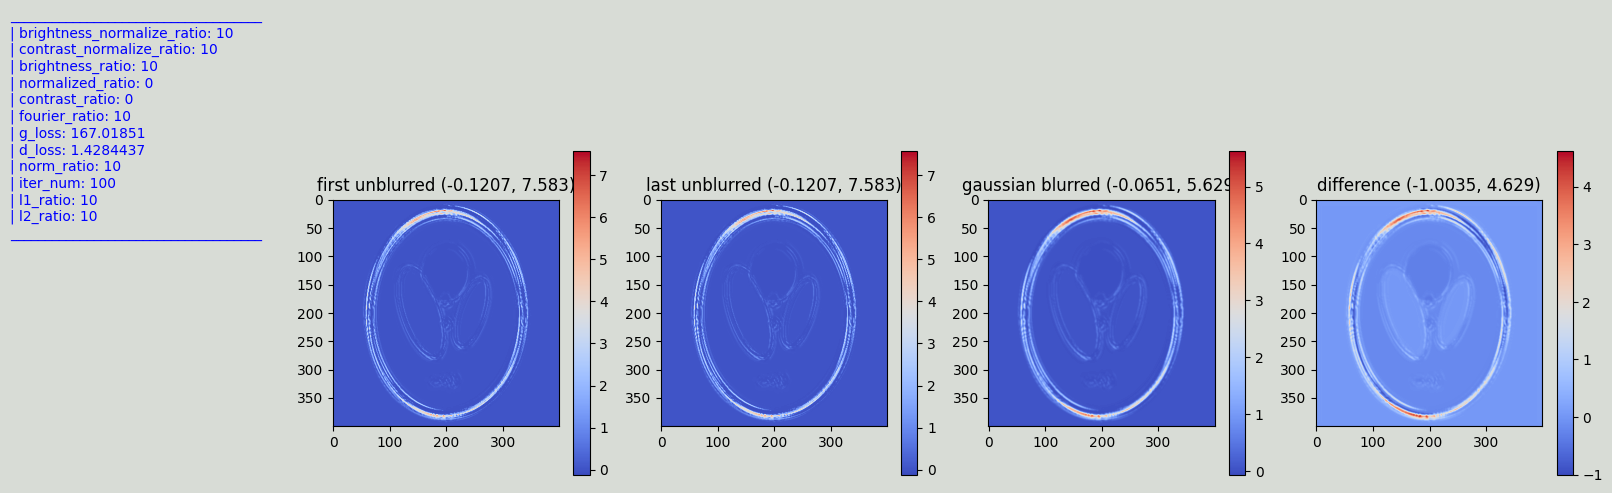

array(1.4284437, dtype=float32)

In [33]:
ratio.update({'g_loss': gen_loss_list[-1], 'd_loss': dis_loss_list[-1], 'iter_num': len(gen_loss_list)})
f = visualize([model.unblurred_list[0], model.unblurred_list[-1], model.blurred, model.difference], dict = ratio, title = ['first unblurred', 'last unblurred', 'gaussian blurred', 'difference'])
ratio.pop('g_loss')
ratio.pop('d_loss')

In [ ]:
ratio.update({'g_loss': gen_loss_list[-1], 'd_loss': dis_loss_list[-1], 'iter_num': len(gen_loss_list)})
f = visualize([model.unblurred_list[0], model.unblurred_list[-1], model.blurred, model.difference], dict = ratio, title = ['first unblurred', 'last unblurred', 'gaussian blurred', 'difference'])
ratio.pop('g_loss')
ratio.pop('d_loss')

In [272]:
ratio

{'d_loss': array(1.2504818, dtype=float32),
 'iter_num': 6000,
 'g_loss': array(1.2430898, dtype=float32)}

____________________________________
| brightness_normalize_ratio: 0 
| contrast_normalize_ratio: 0 
| normalized_ratio: 0 
| brightness_ratio: 0 
| contrast_ratio: 0 
| g_loss: 1.8557768 
| d_loss: 1.3516252 
| fourier_ratio: 0 
| l2_ratio: 10 
| l1_ratio: 0 
____________________________________ 

rows:  1 cols:  4


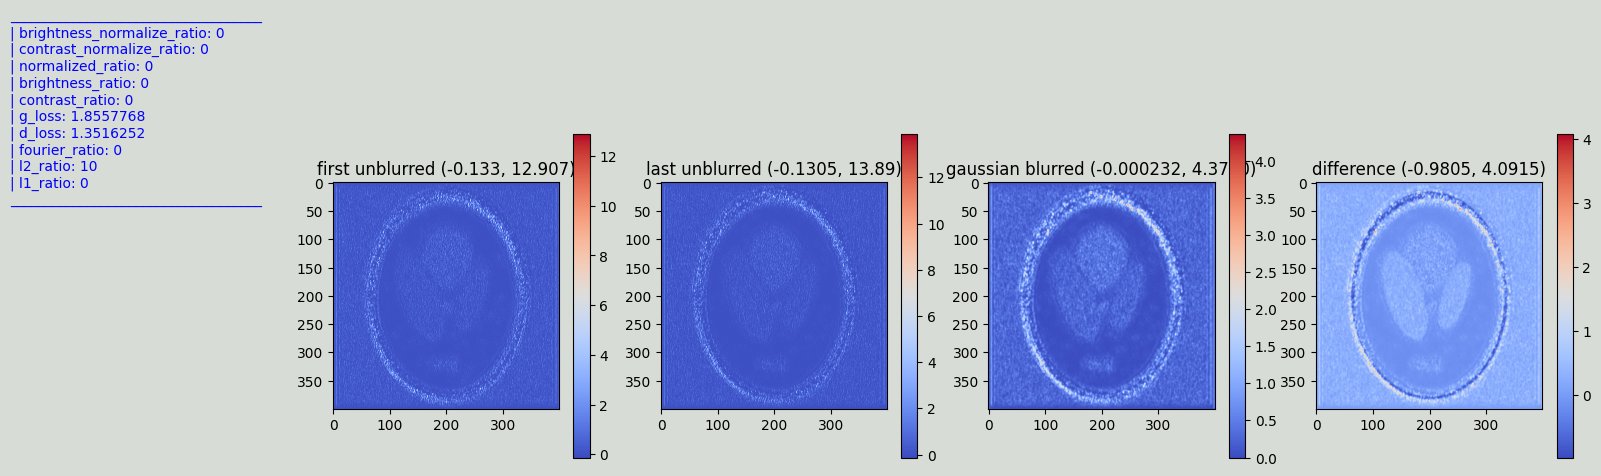

array(1.3516252, dtype=float32)

In [238]:
ratio.update({'g_loss': gen_loss_list[-1], 'd_loss': dis_loss_list[-1]})
f = visualize([model.unblurred_list[0], model.unblurred_list[-1], model.blurred, model.difference], dict = ratio, title = ['first unblurred', 'last unblurred', 'gaussian blurred', 'difference'])
ratio.pop('g_loss')
ratio.pop('d_loss')

____________________________________
| brightness_normalize_ratio: 0 
| contrast_normalize_ratio: 0 
| normalized_ratio: 10 
| brightness_ratio: 0 
| contrast_ratio: 0 
| fourier_ratio: 10 
| g_loss: 28.873333 
| d_loss: 1.2486403 
| l1_ratio: 10 
| l2_ratio: 10 
____________________________________ 

rows:  1 cols:  4


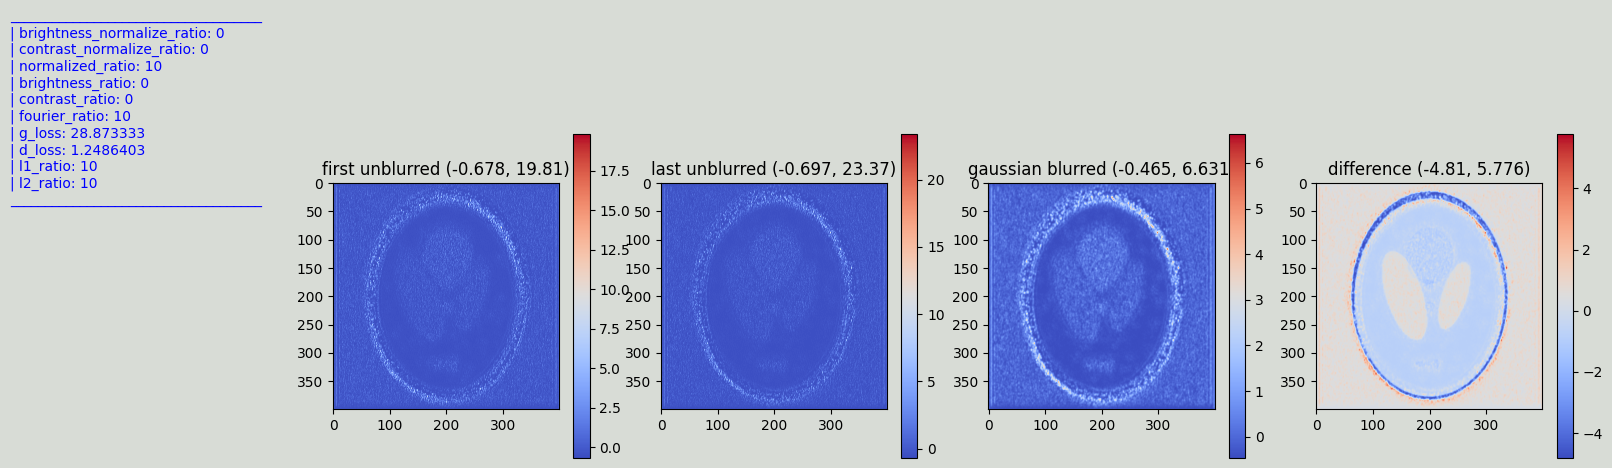

array(1.2486403, dtype=float32)

In [234]:
ratio.update({'g_loss': gen_loss_list[-1], 'd_loss': dis_loss_list[-1]})
f = visualize([model.unblurred_list[0], model.unblurred_list[-1], model.blurred, model.difference], dict = ratio, title = ['first unblurred', 'last unblurred', 'gaussian blurred', 'difference'])
ratio.pop('g_loss')
ratio.pop('d_loss')

In [106]:
model = make_ganrec_model(**dataloader.__dict__)
gen_loss_list, dis_loss_list, propagated_intensity_list = model.train(save_model = False, save_model_path = 'model/ganrec_model', **ratio)

epoch 0 gen_loss:  tensor(1.7174, device='cuda:0', grad_fn=<AddBackward0>) dis_loss:  tensor(1.5059, device='cuda:0', grad_fn=<AddBackward0>) main_diff:  tensor(0.1158, device='cuda:0') t_epoch:  0.03116774559020996 remaining time:  46 seconds metric:  0.1635625
epoch 499 gen_loss:  tensor(1.7226, device='cuda:0', grad_fn=<AddBackward0>) dis_loss:  tensor(1.3711, device='cuda:0', grad_fn=<AddBackward0>) main_diff:  tensor(0.1148, device='cuda:0') t_epoch:  13.189310312271118 remaining time:  31 seconds metric:  0.15923558
epoch 999 gen_loss:  tensor(1.7786, device='cuda:0', grad_fn=<AddBackward0>) dis_loss:  tensor(1.3235, device='cuda:0', grad_fn=<AddBackward0>) main_diff:  tensor(0.1183, device='cuda:0') t_epoch:  26.181607723236084 remaining time:  15 seconds metric:  0.17575458
epoch 1499 gen_loss:  tensor(1.7852, device='cuda:0', grad_fn=<AddBackward0>) dis_loss:  tensor(1.2937, device='cuda:0', grad_fn=<AddBackward0>) main_diff:  tensor(0.1174, device='cuda:0') t_epoch:  39.35026

____________________________________
| brightness_normalize_ratio: 5 
| contrast_normalize_ratio: 5 
| normalized_ratio: 5 
| brightness_ratio: 0 
| contrast_ratio: 0 
| g_loss: 10.242239 
| d_loss: 1.2936598 
| fourier_ratio: 0 
| l1_ratio: 10 
| l2_ratio: 0 
____________________________________ 

rows:  1 cols:  1


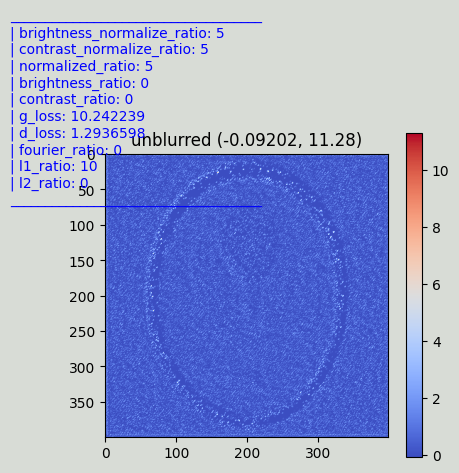

array(1.2936598, dtype=float32)

In [115]:
ratio.update({'g_loss': gen_loss_list[-1], 'd_loss': dis_loss_list[-1]})
f = visualize([model.unblurred_list[-1]], dict = ratio, title = ['unblurred'])
ratio.pop('g_loss')
ratio.pop('d_loss')

In [72]:
ratio

{'l1_ratio': 0,
 'contrast_ratio': 0,
 'normalized_ratio': 0,
 'brightness_ratio': 0,
 'contrast_normalize_ratio': 0,
 'brightness_normalize_ratio': 0,
 'l2_ratio': 5,
 'fourier_ratio': 5,
 'd_loss': array(1.313455, dtype=float32)}

____________________________________
| brightness_normalize_ratio: 0 
| contrast_normalize_ratio: 5 
| normalized_ratio: 0 
| brightness_ratio: 0 
| contrast_ratio: 0 
| fourier_ratio: 1 
| l2_ratio: 10 
| l1_ratio: 5 
____________________________________ 

rows:  1 cols:  1


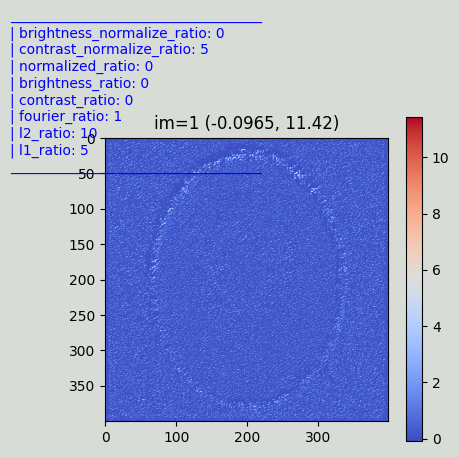

In [56]:
f = visualize([model.unblurred_list[-1]], dict = ratio)

____________________________________
| brightness_normalize_ratio: 0 
| contrast_normalize_ratio: 0 
| normalized_ratio: 0 
| brightness_ratio: 0 
| contrast_ratio: 0 
| fourier_ratio: 1 
| l2_ratio: 10 
| l1_ratio: 0 
____________________________________ 

rows:  1 cols:  1


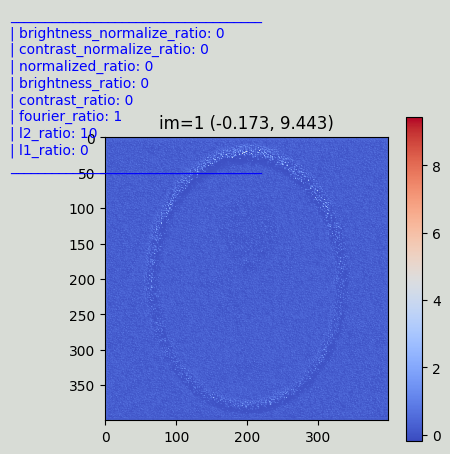

In [22]:
f = visualize([model.unblurred_list[-1]], dict = ratio)

____________________________________
| brightness_normalize_ratio: 0 
| contrast_normalize_ratio: 0 
| normalized_ratio: 0 
| brightness_ratio: 0 
| contrast_ratio: 5 
| fourier_ratio: 5 
| l1_ratio: 5 
| l2_ratio: 5 
____________________________________ 

rows:  1 cols:  1


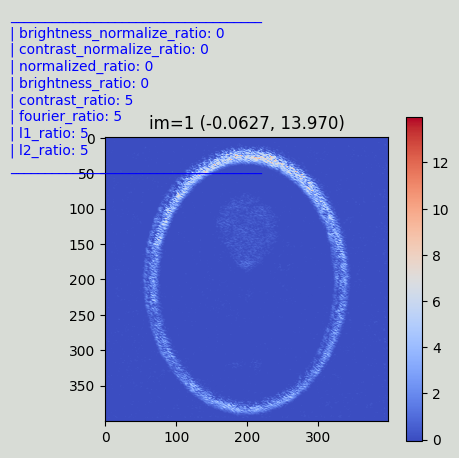

In [25]:
f = visualize([model.unblurred_list[-1]], dict = ratio)

____________________________________
| brightness_normalize_ratio: 0 
| contrast_normalize_ratio: 0 
| normalized_ratio: 0 
| brightness_ratio: 0 
| contrast_ratio: 1 
| fourier_ratio: 10 
| l2_ratio: 10 
| l1_ratio: 0 
____________________________________ 

rows:  1 cols:  1


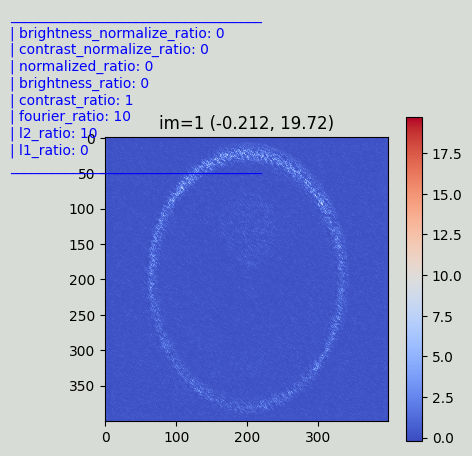

In [18]:
f = visualize([model.unblurred_list[-1]], dict = ratio)

____________________________________
| brightness_normalize_ratio: 0 
| contrast_normalize_ratio: 0 
| normalized_ratio: 5 
| brightness_ratio: 0 
| contrast_ratio: 0 
| fourier_ratio: 10 
| l2_ratio: 10 
| l1_ratio: 0 
____________________________________ 

rows:  1 cols:  1


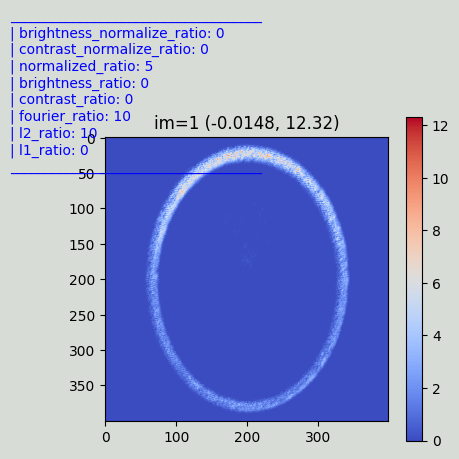

In [14]:
f = visualize([model.unblurred_list[-1]], dict = ratio)

____________________________________
| brightness_normalize_ratio: 0 
| contrast_normalize_ratio: 0 
| normalized_ratio: 5 
| brightness_ratio: 0 
| contrast_ratio: 0 
| fourier_ratio: 1 
| l1_ratio: 10 
| l2_ratio: 0 
____________________________________ 

rows:  1 cols:  1


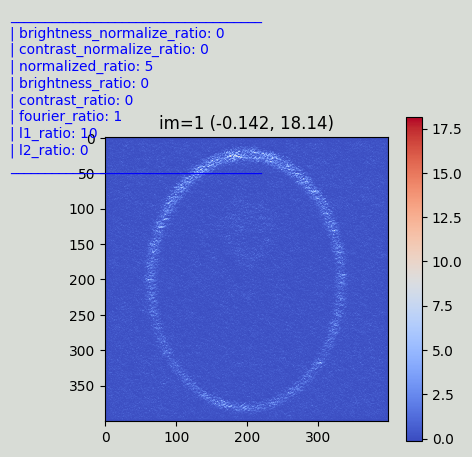

In [31]:
f = visualize([model.unblurred_list[-1]], dict=ratio)

In [237]:
simulation = load_images_parallel(['/beegfs/desy/user/jentscht/for_dawit/groundtruth/mg10gd_screw_60000_eV/ground_truth_projection/ground_truth_projection_attenuation_60000_eV_00000_type_float32_16384x16384.tif', '/beegfs/desy/user/jentscht/for_dawit/groundtruth/mg10gd_screw_60000_eV/ground_truth_projection/ground_truth_projection_phase_60000_eV_00000_type_float32_16384x16384.tif'])
attenuation_image_resized, phase_image_resized = fun_images_parallel(simulation, 'resize', (256, 256))

rows:  1 cols:  3


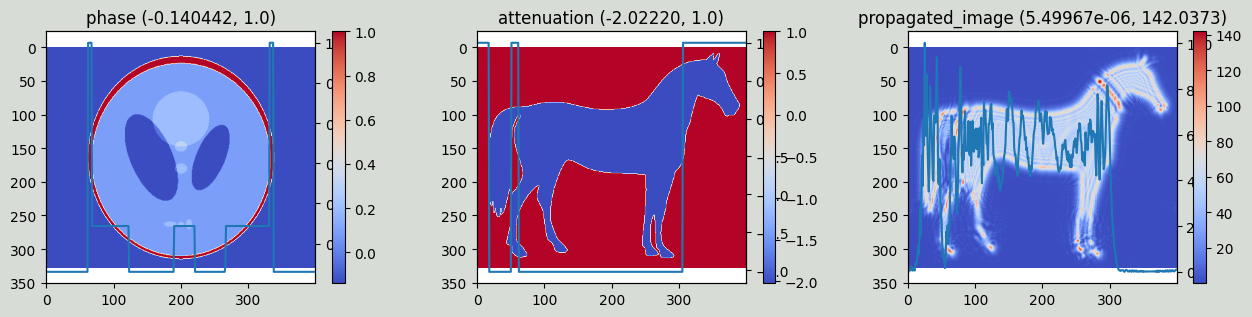

In [408]:
from skimage.data import shepp_logan_phantom, camera, horse
dict = prepare_dict(phase_image = resize(shepp_logan_phantom(), horse().shape), attenuation_image = horse(), fresnel_number = 0.01, propagate=True)
f = visualize([dict['phase'][0], dict['attenuation'][0], dict['image'][0]], show_or_plot='both', title=['phase', 'attenuation', 'propagated_image'])

In [410]:

ratio = {'l1_ratio': 10, 'contrast_ratio': 0, 'normalized_ratio': 5, 'brightness_ratio': 0, 'contrast_normalize_ratio': 0, 'brightness_normalize_ratio': 0, 'l2_ratio': 0, 'fourier_ratio': 1}
info = {
    'downsampling_factor': 2,
    'pad':2,
    'transform_factaor': 0.1,
    'transform_type': 'reshape',
    'mode': 'reflect',
    'value': 'min',
    'device': 'cuda:0',
    'iter_num': 500,
    'abs_ratio': 1,
    'possible_distance_gap': 0,
    'number_of_distances': 0,
}
info.update(dict)
dataloader = Ganrec_Dataloader(**info)

In [411]:
info.update(dict)
dataloader = Ganrec_Dataloader(**info)
condition = 'fresnel_number' 
value = dataloader.kwargs[condition]
values = get_list_of_possibilities(value= dataloader.kwargs[condition], gap = None, number_of_elements = 5)
values = list(dict.fromkeys(np.abs(values)))
print(value, values)

0.01 [0.008, 0.009000000000000001, 0.01, 0.011, 0.012]


rows:  1 cols:  3


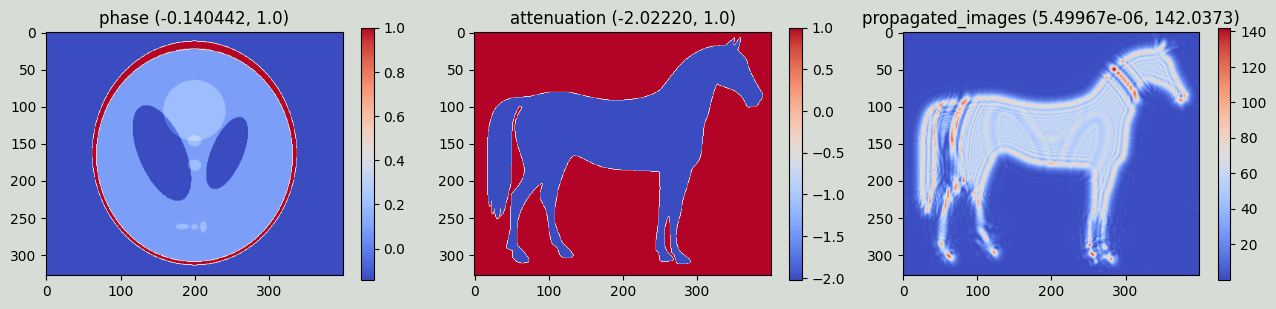

In [413]:
fig = visualize([dataloader.phase[0], dataloader.attenuation[0], dict['image'][0]], title = ['phase', 'attenuation', 'propagated_images'])

In [414]:

import time 
model = make_ganrec_model(**dataloader.kwargs)
time_start = time.time()
x = model.refine_parameters_using_condition(condition, values, change_from_soure=True, info = info, ratio = ratio)

gen_loss:  tensor(195.5637, device='cuda:0', grad_fn=<AddBackward0>) dis_loss:  tensor(1.5087, device='cuda:0', grad_fn=<AddBackward0>) main_diff:  tensor(18.8579, device='cuda:0', grad_fn=<MeanBackward0>) t_epoch:  0.19643855094909668 remaining time:  1 minutes 38 seconds
gen_loss:  tensor(194.1838, device='cuda:0', grad_fn=<AddBackward0>) dis_loss:  tensor(1.5027, device='cuda:0', grad_fn=<AddBackward0>) main_diff:  tensor(18.8584, device='cuda:0', grad_fn=<MeanBackward0>) t_epoch:  0.24213337898254395 remaining time:  1 minutes 38 seconds
gen_loss:  187.2901 dis_loss:  1.351687 main_diff:  18.573051
gen_loss:  tensor(194.0235, device='cuda:0', grad_fn=<AddBackward0>) dis_loss:  tensor(1.5055, device='cuda:0', grad_fn=<AddBackward0>) main_diff:  tensor(18.8565, device='cuda:0', grad_fn=<MeanBackward0>) t_epoch:  0.0481112003326416 remaining time:  24 seconds
gen_loss:  tensor(193.2033, device='cuda:0', grad_fn=<AddBackward0>) dis_loss:  tensor(1.5028, device='cuda:0', grad_fn=<AddBac

(([array(18.573051, dtype=float32),
   array(187.2901, dtype=float32),
   array(1.3493884, dtype=float32)],
  [0.008, 0.008, 0.01]),
 ([array(18.618544, dtype=float32),
   array(187.59288, dtype=float32),
   array(1.3659133, dtype=float32)],
  [0.011, 0.009000000000000001, 0.012]))

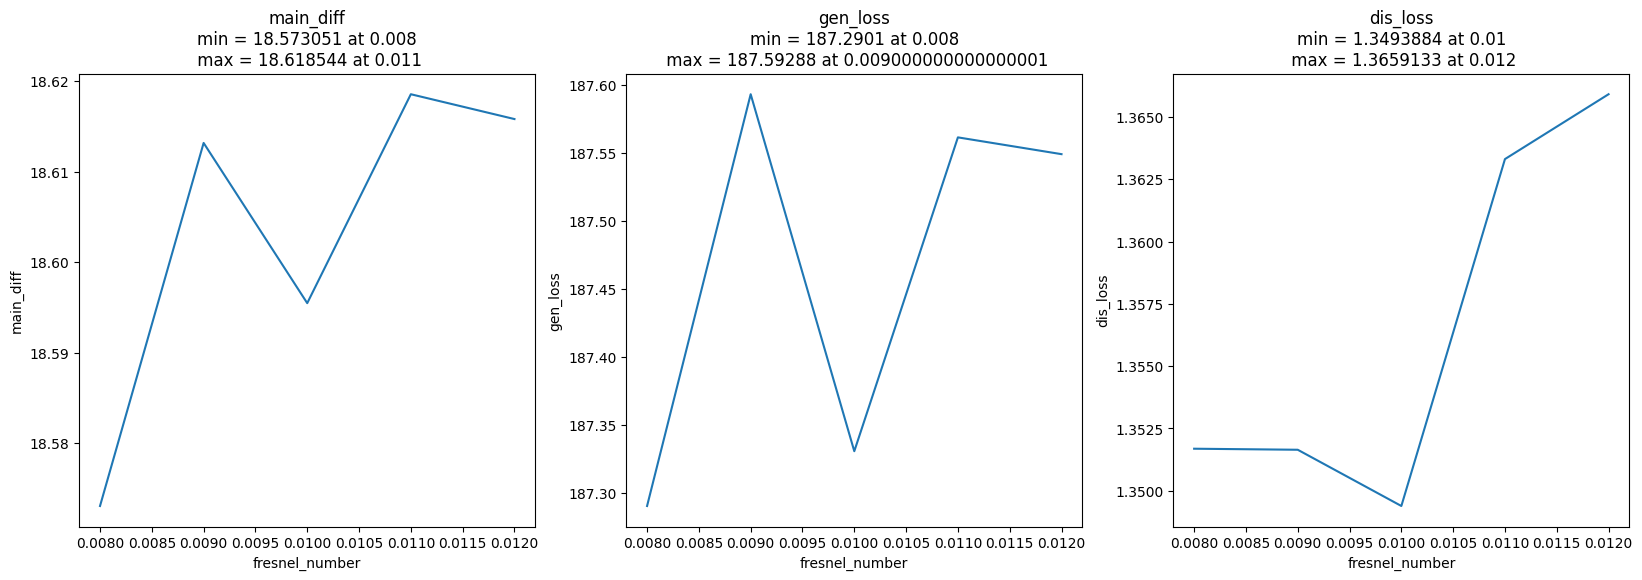

In [415]:
plot_pandas(x[0], ['main_diff', 'gen_loss', 'dis_loss'], x_column = condition)

In [416]:
# if x[5][1][0] in values, find the index
for i, val in enumerate(values):
    if val == x[5][1][0]:
        index = i
print(index)

3


rows:  1 cols:  4


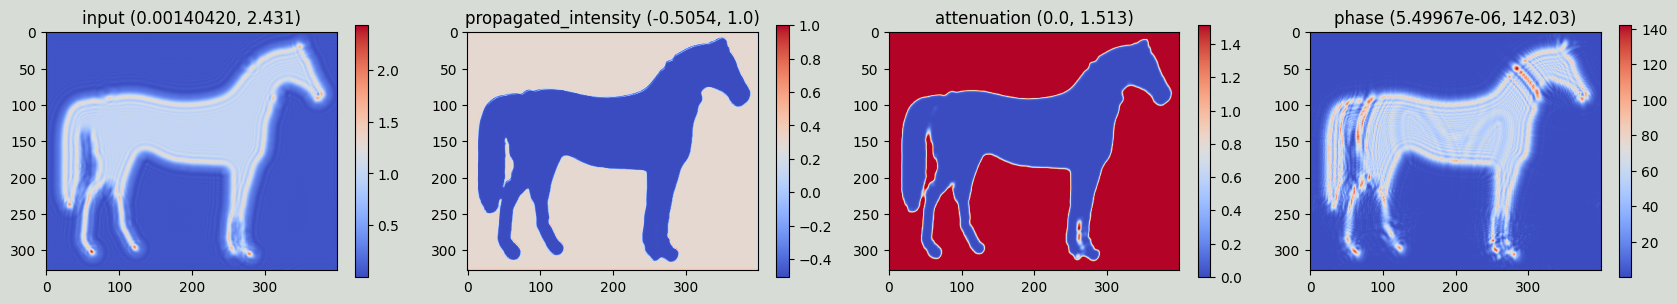

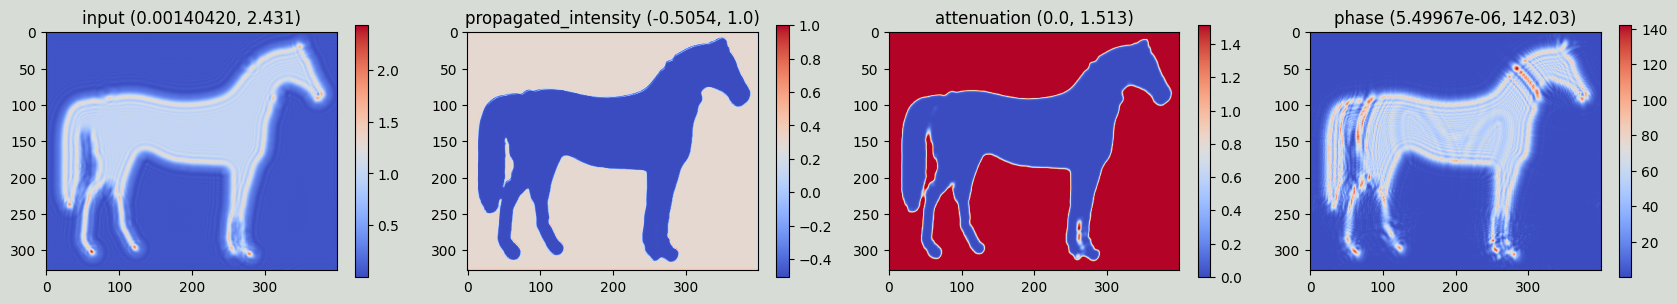

In [417]:
visualize([dataloader.transformed_images, x[1][index], x[2][index], x[3][index]], title = ['input', 'propagated_intensity', 'attenuation', 'phase', 'ground_phase'])

rows:  1 cols:  3


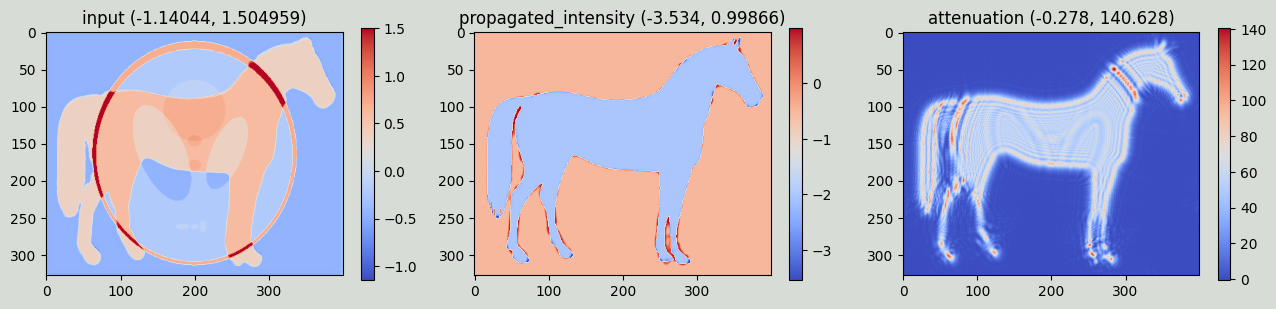

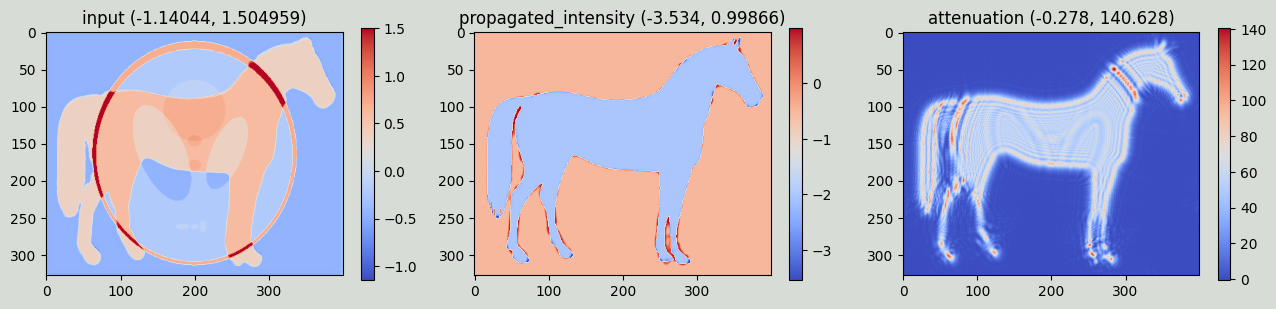

In [420]:
visualize([dataloader.image[0] - x[1][index], dataloader.phase[0] - x[2][index], dataloader.attenuation[0] - x[3][index]], title = ['input', 'propagated_intensity', 'attenuation', 'phase', 'ground_phase'])